In [1]:
%matplotlib notebook

import sys
import os
import time

In [2]:
# paths = ['d:/code/broadbean', 'd:/code/labtools', 'd:/code/v2_dataset_tools']
# for p in paths:
#     if p not in sys.path:
#         sys.path.append(p)

In [3]:
import numpy as np
import qcodes as qc
import broadbean as bb

from matplotlib import pyplot as plt
from broadbean.plotting import plotter

from pytopo.mplplots.init_nb_plotting import *
from pytopo.mplplots import plots as mplplots
from pytopo.mplplots import tools as mpltools

from pytopo.qctools import instruments as instools

# from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path

In [4]:
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter
from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter

In [5]:
import fusion

ModuleNotFoundError: No module named 'fusion'

In [6]:
import fusion.fusion.

SyntaxError: invalid syntax (<ipython-input-6-e93253e7abb3>, line 1)

# Init

## load instruments

In [7]:
# from qcodes.instrument_drivers.QuTech.IVVI import IVVI
# ivvi = instools.create_inst(IVVI, "ivvi", "ASRL5::INSTR")

# from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
# key1 = instools.create_inst(Keysight_34465A, "key1", "USB0::0x2A8D::0x0101::MY57503556::INSTR")

from pytopo.qctools import instruments as instools
from pytopo.rf.alazar_acquisition import RawAcqCtl, DemodAcqCtl, DemodRelAcqCtl, IQAcqCtl, IQRelAcqCtl

inst_list = []

from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = instools.create_inst(AlazarTech_ATS9360, 'alazar')
inst_list.append(alazar)

raw_acq = instools.create_inst(RawAcqCtl, 'raw_acq', 'alazar', force_new_instance=True)
inst_list.append(raw_acq)

demod_acq = instools.create_inst(DemodAcqCtl, 'demod_acq', 'alazar', force_new_instance=True)
inst_list.append(demod_acq)

rel_acq = instools.create_inst(DemodRelAcqCtl, 'rel_acq', 'alazar', force_new_instance=True)
inst_list.append(rel_acq)

iq_acq = instools.create_inst(IQAcqCtl, 'iq_acq', 'alazar', force_new_instance=True)
inst_list.append(iq_acq)

iqrel_acq = instools.create_inst(IQRelAcqCtl, 'iqrel_acq', 'alazar', force_new_instance=True)
inst_list.append(iqrel_acq)

from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
awg5014 = instools.create_inst(Tektronix_AWG5014, 'awg5014', address="TCPIP0::169.254.183.196::inst0::INSTR")
inst_list.append(awg5014)

# inst_list.append(ivvi)
# inst_list.append(key1)

from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
LO = instools.create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.234.107")
RF = instools.create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.2.20")

inst_list.append(LO)
inst_list.append(RF)

station = qc.Station(*inst_list)

Connected to: TEKTRONIX AWG5014C (serial:B051388, firmware:SCPI:99.0 FW:4.6.0.7) in 0.12s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110524, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110525, firmware:3.1.19.15-3.50.124.67) in 0.03s


Snapshot: Could not update parameter:clock_source
Snapshot: Could not update parameter:external_sample_rate
Snapshot: Could not update parameter:sample_rate
Snapshot: Could not update parameter:clock_edge
Snapshot: Could not update parameter:decimation
Snapshot: Could not update parameter:coupling1
Snapshot: Could not update parameter:channel_range1
Snapshot: Could not update parameter:impedance1
Snapshot: Could not update parameter:coupling2
Snapshot: Could not update parameter:channel_range2
Snapshot: Could not update parameter:impedance2
Snapshot: Could not update parameter:trigger_operation
Snapshot: Could not update parameter:trigger_engine1
Snapshot: Could not update parameter:trigger_source1
Snapshot: Could not update parameter:trigger_slope1
Snapshot: Could not update parameter:trigger_level1
Snapshot: Could not update parameter:trigger_engine2
Snapshot: Could not update parameter:trigger_source2
Snapshot: Could not update parameter:trigger_slope2
Snapshot: Could not update par

## Default settings

In [8]:
ats_settings = dict(
    clock_source='INTERNAL_CLOCK',
    sample_rate=int(2e8),
    clock_edge='CLOCK_EDGE_RISING',
    decimation=1,
    coupling=['DC','DC'],
    channel_range=[.4, .4],
    impedance=[50, 50],
    trigger_operation='TRIG_ENGINE_OP_J',
    trigger_engine1='TRIG_ENGINE_J',
    trigger_source1='EXTERNAL',
    trigger_slope1='TRIG_SLOPE_POSITIVE',
    trigger_level1=128+20,
    trigger_engine2='TRIG_ENGINE_K',
    trigger_source2='DISABLE',
    trigger_slope2='TRIG_SLOPE_POSITIVE',
    trigger_level2=128+5,
    external_trigger_coupling='DC',
    external_trigger_range='ETR_2V5',
    trigger_delay=0,
    timeout_ticks=int(1e7),
    aux_io_mode='AUX_IN_AUXILIARY',
    aux_io_param='NONE',
)

station.alazar.config(**ats_settings)

# CW spec

## AWG sequence (to trigger Alazar)

In [9]:
ramp = bb.PulseAtoms.ramp
delay = bb.PulseAtoms.waituntil

<IPython.core.display.Javascript object>


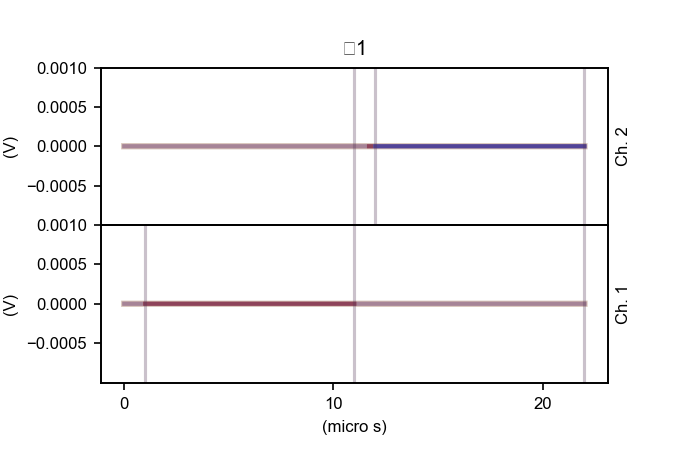

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\axes\_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


In [10]:
SR = 1e9
initial_delay = 1e-6
qb_pulse_len = 1e-5
ro_delay = 1e-6
ro_pulse_len = 1e-5
alz_trigger_len = 100e-9
alz_trigger_buf = 200e-9

spec_elem = bb.Element()

qubit = bb.BluePrint()
qubit.setSR(SR)
qubit.insertSegment(0, ramp, (0, 0), dur=initial_delay)
qubit.insertSegment(-1, ramp, (0, 0), dur=qb_pulse_len, name='qb_pulse')
qubit.insertSegment(-1, ramp, (0, 0), dur=ro_delay + ro_pulse_len)
qubit.setSegmentMarker('qb_pulse', (0, qb_pulse_len), 1)

readout = bb.BluePrint()
readout.setSR(SR)
readout.insertSegment(0, ramp, (0, 0), dur=initial_delay + qb_pulse_len)
readout.insertSegment(-1, ramp, (0, 0), dur=ro_delay, name='ro_delay')
readout.insertSegment(-1, ramp, (0, 0), dur=ro_pulse_len, name='ro_pulse')
readout.setSegmentMarker('ro_delay', (ro_delay - alz_trigger_len - alz_trigger_buf, alz_trigger_len), 1)
readout.setSegmentMarker('ro_pulse', (0, ro_pulse_len), 2)

spec_elem.addBluePrint(2, readout)
spec_elem.addBluePrint(1, qubit)

seq = bb.Sequence()
seq.name = 'qubit_spec'

seq.addElement(1, spec_elem)
seq.setSR(SR)

seq.setChannelAmplitude(1, 1)
seq.setChannelOffset(1, 0)
seq.setChannelAmplitude(2, 1)
seq.setChannelOffset(2, 0)

seq.setSequencingTriggerWait(1, 0)
seq.setSequencingGoto(1, 1)

plotter(seq)

In [11]:
awg5014.stop()
awg5014.clock_freq(SR)
pkg = seq.outputForAWGFile()
awg5014.make_send_and_load_awg_file(*pkg[:])
awg5014.ch1_state(1)
awg5014.ch2_state(1)
awg5014.start()

'Running'

In [12]:
station.RF.frequency(450e6)
station.LO.frequency(458e6)
station.RF.power(-15)
station.LO.power(15)

## Test Alazar signal

In [13]:
demod_acq.acq_time  = 100e-6
demod_acq.demod_frq = 8e6
demod_acq.update_acquisitionkwargs(records_per_buffer=1, 
                                 buffers_per_acquisition=100,
                                 buffer_timeout=10000,
                                 allocated_buffers=1)
data = rel_acq.do_acquisition()
avg_data = np.squeeze(data).mean(axis=0) # .mean(axis=0)

fig, ax = plt.subplots(1, 1)
ax.plot(avg_data.real, label='Re')
ax.plot(avg_data.imag, label='Im')
ax.plot(np.abs(avg_data), label='Abs')
ax.legend()

ax.set_ylabel('Signal')
ax.set_xlabel('Time (us)')

fig.tight_layout()

TypeError: 'float' object is not callable

In [ ]:
rel_acq.acq_time  = 10e-6
rel_acq.demod_frq = 8e6
rel_acq.update_acquisitionkwargs(records_per_buffer=1, 
                                 buffers_per_acquisition=10,
                                 buffer_timeout=10000,
                                 allocated_buffers=1)
data = rel_acq.do_acquisition()
avg_data = np.squeeze(data).mean(axis=0) # .mean(axis=0)

fig, ax = plt.subplots(1, 1)
ax.plot(rel_acq.demod_tvals * 1e6, avg_data.real, label='Re')
ax.plot(rel_acq.demod_tvals * 1e6, avg_data.imag, label='Im')
ax.plot(rel_acq.demod_tvals * 1e6, np.abs(avg_data), label='Abs')
ax.legend()

ax.set_ylabel('Signal')
ax.set_xlabel('Time (us)')

fig.tight_layout()

In [ ]:
iq_acq.acq_time  = 10e-6
iq_acq.demod_frq = 8e6
iq_acq.update_acquisitionkwargs(records_per_buffer=1, 
                                 buffers_per_acquisition=10,
                                 buffer_timeout=10000,
                                 allocated_buffers=1)
data = iq_acq.do_acquisition()

data_chA = data[:,:,0]
data_chB = data[:,:,1]

# print(data_chB)

avg_data = np.squeeze(data).mean(axis=0) # .mean(axis=0)

## Get tvals

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(data_chA.real, label='Re')
ax1.plot(data_chA.imag, label='Im')
ax1.plot(np.abs(data_chA), label='Abs')
ax1.legend()
ax1.set_ylabel('Signal')
ax1.set_xlabel('Time (us)')

ax2.plot(data_chB.real, label='Re')
ax2.plot(data_chB.imag, label='Im')
ax2.plot(np.abs(data_chB), label='Abs')
ax2.legend()
ax2.set_ylabel('Signal')
ax2.set_xlabel('Time (us)')

fig.tight_layout()

## RO spec

In [ ]:
station.ivvi.set_dacs_zero()

In [ ]:
station.RF.frequency(500e6)
station.LO.frequency(500e6)
station.RF.power(-15)
station.LO.power(15)

In [ ]:
station.ivvi.dac1.set_step = 100

In [ ]:
@getter([('I', ''), ('Q', ''), ('Abs', '')])
def measure_IQ():
    data = iq_acq.do_acquisition()
#     data = rel_acq.do_acquisition()
    data = data.mean()
    result = data.real.astype(float), data.imag.astype(float), np.abs(data).astype(float)
    return result

iq_acq.acq_time = 100e-6
iq_acq.demod_frq = 8e6
iq_acq.update_acquisitionkwargs(records_per_buffer=1, 
                                buffers_per_acquisition=100,
                                buffer_timeout=10000,
                                allocated_buffers=1)

frqs = np.linspace(1e6, 1000e6, 501)

setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

result = do_experiment(
    "ref-transmon/resonator-spec",
    setup,
    nest(
        szip(
            sweep(LO.frequency, frqs + 8e6),
            sweep(RF.frequency, frqs),
        ),
        measure_IQ,
    ),
    cleanup,
    return_format=["data_set_path", "dataset"],
    live_plot_axes=[{'RF_frequency': 1, 'Abs' : 4},]
)

In [ ]:
@getter([('I', ''), ('Q', ''), ('Abs', '')])
def measure_IQ():
    data = iqrel_acq.do_acquisition()
#     data = rel_acq.do_acquisition()
    data = data.mean()
    result = data.real.astype(float), data.imag.astype(float), np.abs(data).astype(float)
    return result

iqrel_acq.acq_time = 100e-6
iqrel_acq.demod_frq = 8e6
iqrel_acq.update_acquisitionkwargs(records_per_buffer=1, 
                                buffers_per_acquisition=1000,
                                buffer_timeout=10000,
                                allocated_buffers=1)

frqs = np.linspace(200e6, 1000e6, 1601)
station.ivvi.dac4.set(-530)


station.RF.power(-15)
station.LO.power(15)

station.RF.frequency(463.38e6)
station.LO.frequency(463.38e6+8e6)


setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

result = do_experiment(
    "ref-transmon/resonator-spec",
    setup,
    nest(
#         sweep(ivvi.dac4, np.linspace(-500, -550, 51)),
#         sweep(ivvi.dac1, np.linspace(-1000, 1000, 101)),
        szip(
            sweep(LO.frequency, frqs + 8e6),
            sweep(RF.frequency, frqs),
        ),
        measure_IQ,
    ),
    cleanup,
    return_format=["data_set_path", "dataset"],
    live_plot_axes=[{'RF_frequency': 1, 'Abs' : 4},]
)

In [ ]:
# ds = qc.load_by_id(277) #  
ds = result[1]
f = np.array(ds.get_values('RF_frequency'))
# f = np.array(ds.get_values('ivvi_dac1'))

sig = np.array(ds.get_values('Abs'))
i = np.array(ds.get_values('I'))
q = np.array(ds.get_values('Q'))


a = np.sqrt(i**2+q**2)

sigdb = 20*np.log10(sig)

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(f, sig, '-')
ax1.plot(f, a)
ax1.set_xlabel('f (Hz)')
ax1.set_ylabel('Reflected signal (a.u.)')
ax1.grid(dashes=[2,2])
ax1.set_title('Experiment ID = {}'.format(ds.run_id), size='small')

ax2.plot(f, sigdb, '-')
ax2.set_xlabel('f (Hz)')
ax2.set_ylabel('Reflected signal (a.u.)')
ax2.grid(dashes=[2,2])
ax2.set_title('Experiment ID = {}'.format(ds.run_id), size='small')

fig.tight_layout()

In [ ]:
dv = result[1]

rf    = np.unique(np.array(dv.get_values('RF_frequency'))[:,0])
t4     = np.unique(np.array(dv.get_values("ivvi_dac4"))[:,0])
Z     = np.array(dv.get_values('Abs'))[:,0]

t4 = t4[::-1]

rf_idx = np.argmin(rf<470e6)
t4_idx1 = np.argmin(t4>-560)
t4_idx2 = np.argmin(t4>-600)
# print(rf_idx, t4_idx1, t4_idx2)

Z = Z.reshape((t4.size, rf.size))

fig, (ax1, ax3) = plt.subplots(1, 2)
ax1.pcolor(rf,t4,Z)
ax1.set_xlabel("rf freq (Hz)")
ax1.set_ylabel("T1 (mV) (mV)")

# ax2.plot(t4[::-1], Z[:,rf_idx])

ax3.plot(rf, Z[t4_idx1,:])
ax3.plot(rf, Z[t4_idx2,:])

fig.tight_layout()

In [ ]:
dv = result[1]

t4    = np.unique(np.array(dv.get_values('ivvi_dac4'))[:,0])
t1    = np.unique(np.array(dv.get_values('ivvi_dac1'))[:,0])
Z     = np.array(dv.get_values('Abs'))[:,0]

t4 = t4[::-1]

# rf_idx = np.argmin(rf<470e6)
t4_idx1 = np.argmin(t4>-542)
t4_idx2 = np.argmin(t4>-525)
# print(rf_idx, t4_idx1, t4_idx2)

Z = Z.reshape((t4.size, t1.size))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,3))
ax1.pcolor(t1*1e-3, t4, Z)
ax1.set_ylabel("T1 (mV)")
ax1.set_xlabel("bias (mV)")
ax1.axhline(y=t4[t4_idx1])
ax1.axhline(y=t4[t4_idx2], color="orange")

ax2.plot(t1*1e-3, Z[t4_idx1,:], label = "T1 = " + str(t4[t4_idx1]) + " mV")
ax2.plot(t1*1e-3, Z[t4_idx2,:], label = "T1 = " + str(t4[t4_idx2]) + " mV")

ax2.set_xlabel("bias (mV)")
ax2.set_ylabel("Reflected signal (a.u.)")
ax2.legend(loc=0)

fig.tight_layout()

In [ ]:
@getter([('I', ''), ('Q', ''), ('Abs', '')])
def measure_IQ():
    data = iqrel_acq.do_acquisition()
#     data = rel_acq.do_acquisition()
    data = data.mean()
    result = data.real.astype(float), data.imag.astype(float), np.abs(data).astype(float)
    return result

iqrel_acq.acq_time = 10e-6
iqrel_acq.demod_frq = 8e6
iqrel_acq.update_acquisitionkwargs(records_per_buffer=1, 
                                buffers_per_acquisition=10,
                                buffer_timeout=10000,
                                allocated_buffers=1)

# rel_acq.acq_time = 98e-6
# rel_acq.demod_frq = 20e6
# rel_acq.update_acquisitionkwargs(records_per_buffer=1, 
#                                  buffers_per_acquisition=1000,
#                                  buffer_timeout=10000,
#                                  allocated_buffers=1)

station.ivvi.dac4.set(-530)
frqs = np.linspace(445e6, 465e6, 101)

station.RF.frequency(455.57e6)
station.LO.frequency(455.57e6+8e6)


setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

result = do_experiment(
    "ref-transmon/resonator-spec",
    setup,
    nest(
        sweep(ivvi.dac4, np.linspace(-500, -550, 21)),
        sweep(ivvi.dac1, np.linspace(-1000, 1000, 101)),
#         szip(
#             sweep(LO.frequency, frqs + 8e6),
#             sweep(RF.frequency, frqs),
#         ),
        measure_IQ,
    ),
    cleanup,
    return_format=["data_set_path", "dataset"],
    live_plot_axes=[{'dac1': 2, 'Abs' : 5},]
)

In [ ]:
ramp = bb.PulseAtoms.ramp

SR = 1e9
initial_delay = 1e-6
alz_trigger_len = 100e-9
alz_buf = 1e-6
rep_rate = 100e-6

spec_elem = bb.Element()

readout = bb.BluePrint()
readout.setSR(SR)
readout.insertSegment(0, ramp, (0, 0), dur=rep_rate, name='ro_segment')
readout.setSegmentMarker('ro_segment', (initial_delay, alz_trigger_len), 1)
readout.setSegmentMarker('ro_segment', (initial_delay + alz_buf, rep_rate - initial_delay - 2*alz_buf), 2)

qubit = bb.BluePrint()
qubit.setSR(SR)
qubit.insertSegment(0, ramp, (0, 0), dur=rep_rate, name='spec_segment')
qubit.setSegmentMarker('spec_segment', (initial_delay + alz_buf, rep_rate - initial_delay - 2*alz_buf), 1)


spec_elem.addBluePrint(1, readout)
spec_elem.addBluePrint(2, qubit)

seq = bb.Sequence()
seq.name = 'spec'

seq.addElement(1, spec_elem)
seq.setSR(SR)

seq.setChannelAmplitude(1, 1)
seq.setChannelOffset(1, 0)
seq.setChannelAmplitude(2, 1)
seq.setChannelOffset(2, 0)

seq.setSequencingTriggerWait(1, 0)
seq.setSequencingGoto(1, 1)

# plotter(seq)
